In [108]:
# Import data wrangling libraries
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
import pandas as pd
import seaborn as sns
import time
import datetime
import traceback

from scipy.stats import boxcox
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot

import warnings
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
 
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from matplotlib import pyplot

from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.arima_model import ARIMA

# Ford GoBike Bike Ride Forecasting

## Table of Contents
* [9. Framing the Problem](#9.-Framing-the-Problem)
* [10. Persistence Model](#10.-Persistence-Model)
	* [10.1. Persistence Daily Forecast](#10.1.-Persistence-Daily-Forecast)
	* [10.2. Persistence Hourly Forecast](#10.2.-Persistence-Hourly-Forecast)
* [11. Autoregressive Integrated Moving Average Model (ARIMA)](#11.-Autoregressive-Integrated-Moving-Average-Model)
	* [11.1. ARIMA Daily Forecast](#11.1.-ARIMA-Daily-Forecast)
	* [11.2. ARIMA Hourly Forecast](#11.2.-ARIMA-Hourly-Forecast)
* [12. Long Short-Term Memory Recurrent Neural Network Model (LSTM RNN)](#12.-Long-Short--Term-Memory-Recurrent-Neural Network-Model)
	* [12.1. LSTM RNN Daily Forecast](#12.1.-LSTM-RNN-Daily-Forecast)
	* [12.2. LSTM RNN Hourly Forecast](#12.2.-LSTM-RNN-Hourly-Forecast)
* [13. Model Enhancements](#13.-Model-Enhancements)
* [14. Limitations](#14.-Limitations)
* [15. Future Work](#15.-Future-Work)
* [16. Major Findings and Client Recommendations](#16.-Major-Findings-and-Client-Recommendations)
* [17. Acknowledgements](#17.-Acknowledgements)

In [109]:
%store -r start_time_daily
%store -r start_time_hourly
%store -r log_start_time_hourly
%store -r daily_stationary
%store -r hourly_stationary
%store -r fb

## 9. Framing the Problem

The time series forecasting problem is framed as a supervised learning problem. Both linear and nonlinear models were used to develop predictions of both hourly and daily downsampled data. Both daily and hourly data were used for these forecasts to determine the advantages and disadvantages of the chosen forecasting models at differing time steps. A non-seasonal Autoregressive Integrated Moving Average (ARIMA) model was chosen as the linear forecasting model, while a Long Short-Term Memory Recurrent Neural Network (LSTM RNNs) model was chosen as the nonlinear forecasting model. These models were compared to a persistence model, or naive model, for a baseline comparison. 

The models were assessed using walk-forward validation (rolling forecast) that outputs the model RMSE. The benefit of RMSE is that it penalizes large errors and the scores are in the same units as the forecast values. The walk-forward validation method was used because, in practice, time-dependent models are typically retrained as new data becomes available. This would give the model the best opportunity to make good forecasts at each time step. 

In [110]:
def train_test_split(df):
    # plot train-test split of time series data
    X = df.values.flatten()
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:len(X)]
    print('Observations: %d' % (len(X)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    return train, test

Observations: 187
Training Observations: 123
Testing Observations: 64


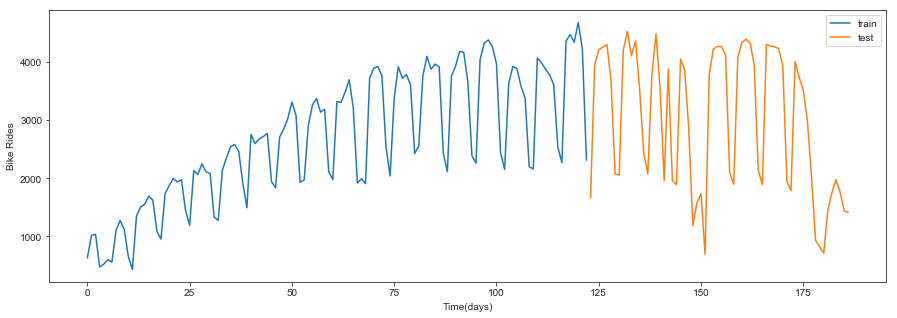

In [111]:
train, test = train_test_split(start_time_daily)
plt.figure(figsize=(15,5))
plt.plot(train)
plt.plot([None for i in train] + [x for x in test])
plt.xlabel('Time(days)')
plt.ylabel('Bike Rides')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Observations: 4479
Training Observations: 2956
Testing Observations: 1523


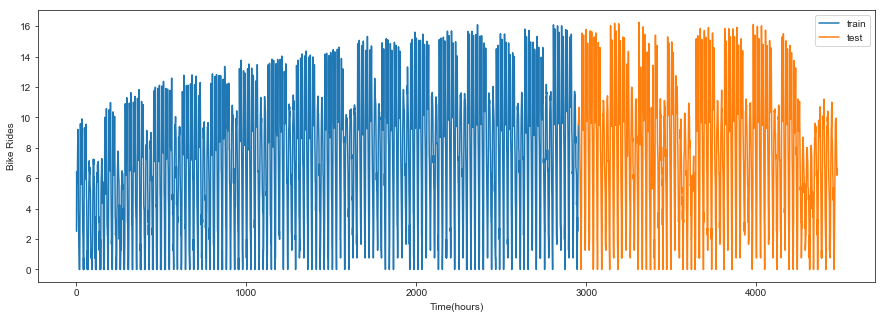

In [112]:
# plot train-test split of time series data
train, test = train_test_split(log_start_time_hourly)
plt.figure(figsize=(15,5))
plt.plot(train)
plt.plot([None for i in train] + [x for x in test])
plt.xlabel('Time(hours)')
plt.ylabel('Bike Rides')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## 10. Persistence Model

### 10.1. Persistence Daily Forecast

The persistence algorithm uses the value at the current time step (t) to predict the expected outcome at the next time step (t+1). In this way, the method exhibits the following qualities:
- Simple: A method that requires little or no training or intelligence.
- Fast: A method that is fast to implement and computationally trivial to make a prediction.
- Repeatable: A method that is deterministic, meaning that it produces an expected output given the same input.


In [165]:
# evaluate a persistence forecast model
# create lagged dataset
def persistence_model(lst, xlabel, ylabel):
    values = lst
    dataframe = pd.concat([values.shift(1), values], axis=1)
    dataframe.columns = ['t', 't+1']
    print(dataframe.head(5))
    # split into train and test sets
    X = dataframe.values
    train_size = int(len(X) * 0.66)
    train, test = X[1:train_size], X[train_size:]
    train_X, train_y = train[:,0], train[:,1]
    test_X, test_y = test[:,0], test[:,1]
    # persistence model = x
    # walk-forward validation
    predictions = list()
    for x in test_X:
        yhat = x
        predictions.append(yhat)
    rmse = sqrt(mean_squared_error(test_y, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot predictions and expected results
    plt.figure(figsize=(15,5))
#     plt.plot(train_y)
#     plt.plot([None for i in train_y] + [x for x in test_y])
#     plt.plot([None for i in train_y] + [x for x in predictions],)
    plt.plot([x for x in test_y])
    plt.plot([x for x in predictions],)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['test', 'prediction'], loc='upper right')
    plt.show()

        t   t+1
0     NaN   632
1   632.0  1019
2  1019.0  1038
3  1038.0   475
4   475.0   523
Test RMSE: 1117.936


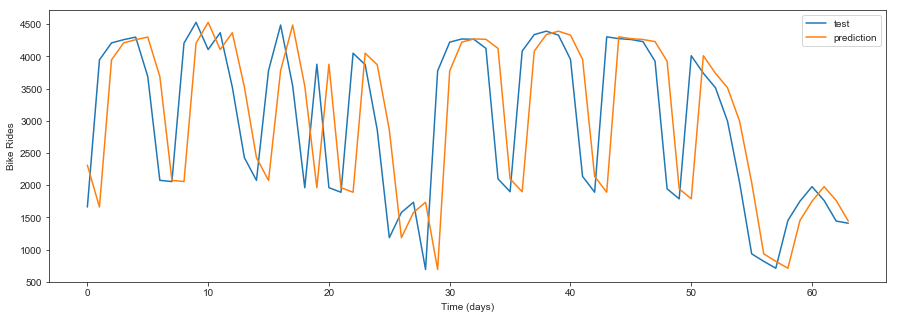

In [166]:
persistence_model(pd.DataFrame(start_time_daily.values.flatten()), 'Time (days)', 'Bike Rides')

### 10.2. Persistence Hourly Forecast

          t       t+1
0       NaN  2.508410
1  2.508410  6.428513
2  6.428513  5.596048
3  5.596048  6.313039
4  6.313039  6.069744
Test RMSE: 1.766


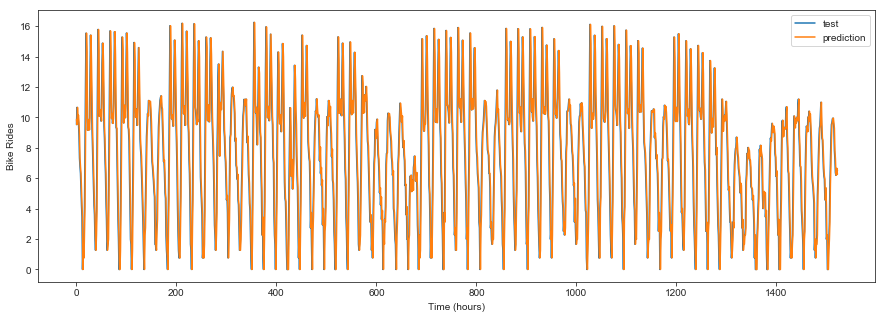

In [167]:
persistence_model(pd.DataFrame(log_start_time_hourly.values.flatten()), 'Time (hours)', 'Bike Rides')

## 11. Autoregressive Integrated Moving Average Model

A non-seasonal ARIMA model is based on a linear combination of autoregression terms, moving average terms with differencing (for stationarity). The model assumes stationarity and normality of residuals, which must be checked for model validity.

ARIMA parameters:
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

### 11.1. ARIMA Daily Forecast

In [116]:
# grid search ARIMA parameters for a time series
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        # model_fit = model.fit(disp=0)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [119]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(start_time_daily.values.flatten(), p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=1940.125
ARIMA(0, 1, 1) RMSE=1143.720
ARIMA(0, 1, 2) RMSE=959.313
ARIMA(0, 1, 3) RMSE=968.219
ARIMA(0, 2, 1) RMSE=1121.848
ARIMA(0, 2, 2) RMSE=1146.544
ARIMA(1, 0, 0) RMSE=1104.556
ARIMA(1, 1, 0) RMSE=1125.058
ARIMA(1, 1, 1) RMSE=1022.555
ARIMA(1, 2, 0) RMSE=1535.831
ARIMA(2, 0, 0) RMSE=1111.538
ARIMA(2, 1, 0) RMSE=1055.396
ARIMA(2, 1, 1) RMSE=974.922
ARIMA(2, 1, 2) RMSE=913.827
ARIMA(2, 2, 0) RMSE=1342.028
ARIMA(2, 2, 2) RMSE=1002.674
ARIMA(3, 0, 0) RMSE=1050.517
ARIMA(3, 1, 0) RMSE=1057.147
ARIMA(3, 1, 1) RMSE=985.104
ARIMA(3, 2, 0) RMSE=1329.200
ARIMA(4, 0, 0) RMSE=1052.943
ARIMA(4, 1, 0) RMSE=1011.924
ARIMA(4, 1, 1) RMSE=930.783
ARIMA(4, 2, 0) RMSE=1328.699
ARIMA(4, 2, 2) RMSE=971.934
Best ARIMA(2, 1, 2) RMSE=913.827


RMSE: 880.131
                 0
count    64.000000
mean      0.000001
std     887.088467
min   -1997.858007
25%    -651.161078
50%     -56.317142
75%     456.972663
max    1863.418209


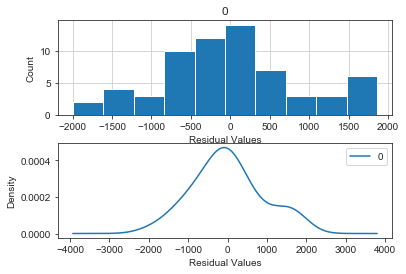

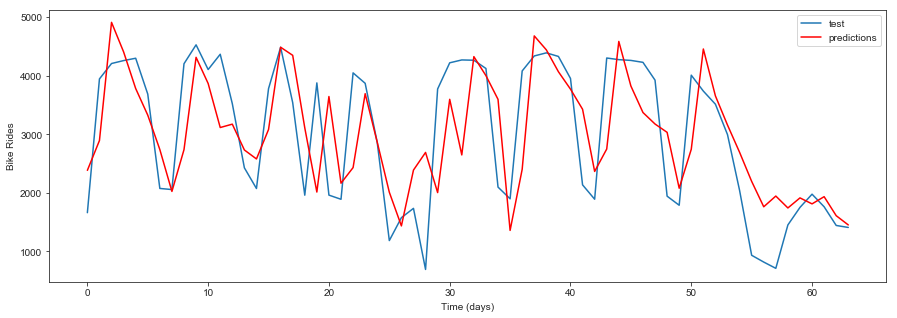

In [164]:
# summarize residual errors for an ARIMA model
# prepare data
X = start_time_daily.values.flatten()
X = X.astype('float32')
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = -245.865450
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot residual errors
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.xlabel('Residual Values')
plt.ylabel('Count')
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.xlabel('Residual Values')
plt.show()

# Plot test vs. predictions
plt.figure(figsize=(15,5))
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['test', 'predictions'], loc='upper right')
plt.xlabel('Time (days)')
plt.ylabel('Bike Rides')
plt.show()

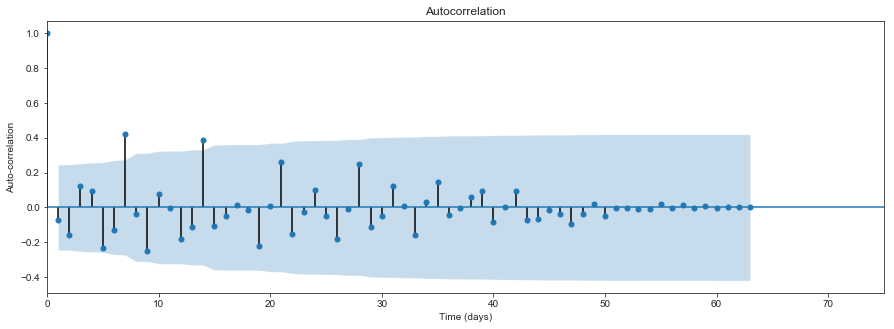

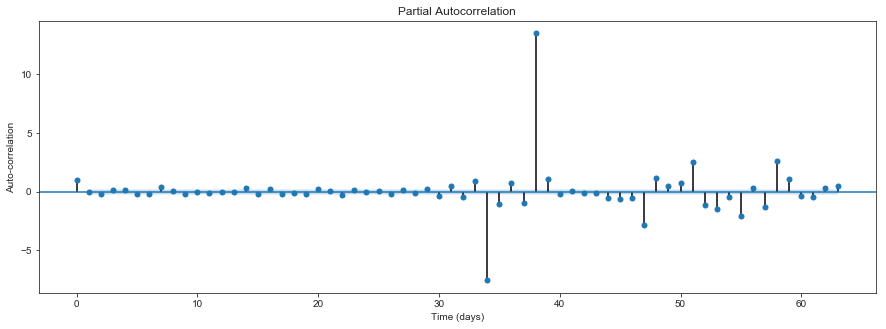

In [152]:
plt.figure(figsize=(15,5))
plot_acf(residuals, ax=plt.gca())
plt.xlim(0,75)
plt.xlabel('Time (days)')
plt.ylabel('Auto-correlation')
plt.show()

plt.figure(figsize=(15,5))
plot_pacf(residuals, ax=plt.gca(),lags=75)
plt.xlabel('Time (days)')
plt.ylabel('Auto-correlation')
plt.show()

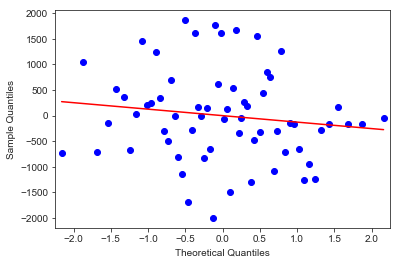

In [153]:
qqplot(residuals, line='r')
plt.show()

### 11.2. ARIMA Hourly Forecast

In [70]:
# grid search ARIMA parameters for a time series
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 1)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(hourly_stationary.values.flatten(), p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=2.365
ARIMA(1, 0, 0) RMSE=0.722
ARIMA(1, 0, 1) RMSE=0.687
ARIMA(1, 0, 2) RMSE=0.657
ARIMA(2, 0, 0) RMSE=0.669
Best ARIMA(1, 0, 2) RMSE=0.657


RMSE: 0.657
                 0
count  1523.000000
mean      0.083715
std       0.651483
min      -2.552127
25%      -0.301370
50%       0.046058
75%       0.403505
max       2.985331


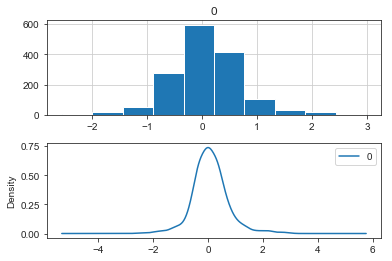

In [71]:
# summarize residual errors for an ARIMA model
# prepare data
X = hourly_stationary.values.flatten()
X = X.astype('float32')
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 0.0
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(1,0,2))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# summarize residual errors
residuals2 = [test[i]-predictions[i] for i in range(len(test))]
residuals2 = DataFrame(residuals)
print(residuals2.describe())
# plot residual errors
plt.figure()
plt.subplot(211)
residuals2.hist(ax=plt.gca())
plt.xlabel('Residual Values')
plt.ylabel('Count')
plt.subplot(212)
residuals2.plot(kind='kde', ax=plt.gca())
plt.xlabel('Residual Values')
plt.show()

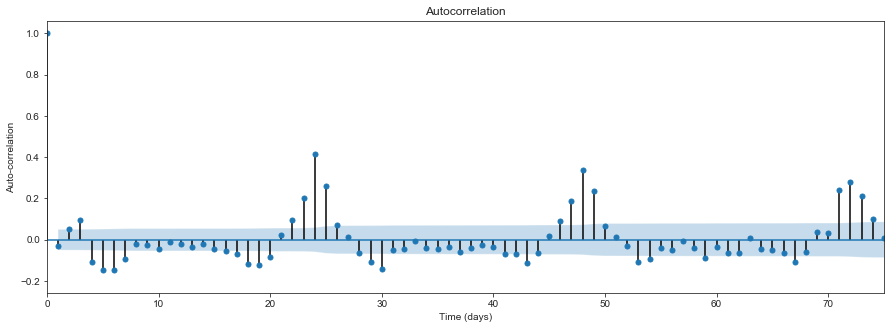

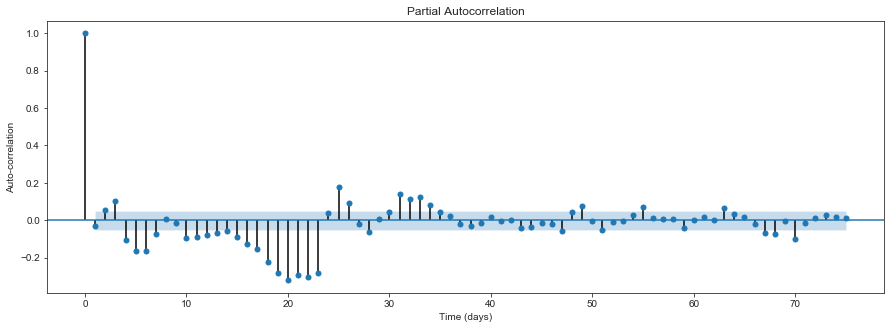

In [82]:
plt.figure(figsize=(15,5))
plot_acf(residuals2, ax=plt.gca())
plt.xlim(0,75)
plt.xlabel('Time (days)')
plt.ylabel('Auto-correlation')
plt.show()

plt.figure(figsize=(15,5))
plot_pacf(residuals2, ax=plt.gca(),lags=75)
plt.xlabel('Time (days)')
plt.ylabel('Auto-correlation')
plt.show()

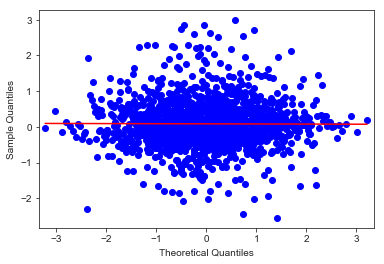

In [83]:
qqplot(residuals2, line='r')
plt.show()

In [99]:
# save finalized model to file
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__
# prepare data
X = hourly_stationary.values.flatten()
X = X.astype('float32')
# fit model
model = ARIMA(X, order=(1,0,2))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = 0
# save model
model_fit.save('model2.pkl')
np.save('model_bias2.npy', [bias])

In [100]:
# separate out a validation dataset
series = hourly_stationary.values.flatten()
split_point = len(series) - 1000
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
pd.DataFrame(dataset).to_csv('dataset2.csv')
pd.DataFrame(validation).to_csv('validation2.csv')

Dataset 3479, Validation 1000


RMSE: 0.706


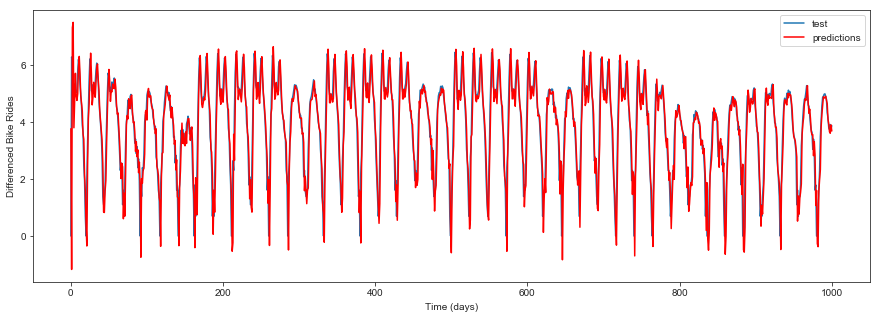

In [103]:
# load and evaluate the finalized model on the validation dataset
# prepare datasets
X = hourly_stationary.values.flatten().astype('float32')
history = [x for x in X]
validation = read_csv('validation2.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model2.pkl')
bias = numpy.load('model_bias2.npy')
# make first prediction
predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
# print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,0,2))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
#     print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
plt.figure(figsize=(15,5))
plt.plot(y)
plt.plot(predictions, color='red')
plt.legend(['test', 'predictions'], loc='upper right')
plt.xlabel('Time (days)')
plt.ylabel('Differenced Bike Rides')
plt.show()

## 12. Long Short-Term Memory Recurrent Neural Network

An LSTM RNN is a type of deep neural network model that is better at retaining long-term temporal “memory” over a traditional RNN, which has better capabilities with short-term “memory.” LSTM RNNs accomplish this by including a “memory cell” where a set of gates is used to control when information enters the memory, outputs, and forgotten. Although not required, the hourly and daily data was differenced to ensure stationarity. LSTM typically performs better if the data is stationary.

Network Architecture:
1. Input Layer
2. LSTM Layer
3. Dropout Layer
4. Full Connected Layer
5. Output Layer

Parameters:
- n input: The number of lag observations to use as input to the model.
- n nodes: The number of LSTM units to use in the hidden layer.
- n epochs: The number of times to expose the model to the whole training dataset.
- n batch: The number of samples within an epoch after which the weights are updated.
- n diff: The difference order or 0 if not used.

### 12.1. LSTM RNN Daily Forecast

Epoch 1/200
35/35 [==============================] - 1s 29ms/step - loss: 1126472.3750
Epoch 2/200
35/35 [==============================] - 0s 2ms/step - loss: 1130732.5000
Epoch 3/200
35/35 [==============================] - 0s 2ms/step - loss: 961694.3750
Epoch 4/200
35/35 [==============================] - 0s 2ms/step - loss: 1150187.2500
Epoch 5/200
35/35 [==============================] - 0s 2ms/step - loss: 1177410.5000
Epoch 6/200
35/35 [==============================] - 0s 2ms/step - loss: 1013211.3125
Epoch 7/200
35/35 [==============================] - 0s 2ms/step - loss: 1005621.6250
Epoch 8/200
35/35 [==============================] - 0s 1ms/step - loss: 1112925.6250
Epoch 9/200
35/35 [==============================] - 0s 3ms/step - loss: 1014265.5000
Epoch 10/200
35/35 [==============================] - 0s 2ms/step - loss: 1019948.0000
Epoch 11/200
35/35 [==============================] - 0s 2ms/step - loss: 1118685.1250
Epoch 12/200
35/35 [==============================] 

Epoch 96/200
35/35 [==============================] - 0s 4ms/step - loss: 1196065.5000
Epoch 97/200
35/35 [==============================] - 0s 3ms/step - loss: 1263330.0000
Epoch 98/200
35/35 [==============================] - 0s 3ms/step - loss: 1334726.0000
Epoch 99/200
35/35 [==============================] - 0s 5ms/step - loss: 1505456.1250
Epoch 100/200
35/35 [==============================] - 0s 5ms/step - loss: 967830.7500
Epoch 101/200
35/35 [==============================] - 0s 4ms/step - loss: 1583594.0000
Epoch 102/200
35/35 [==============================] - 0s 3ms/step - loss: 2958667.7500
Epoch 103/200
35/35 [==============================] - 0s 3ms/step - loss: 1095077.8750
Epoch 104/200
35/35 [==============================] - 0s 3ms/step - loss: 965511.4375
Epoch 105/200
35/35 [==============================] - 0s 2ms/step - loss: 1248769.0000
Epoch 106/200
35/35 [==============================] - 0s 2ms/step - loss: 1121393.5000
Epoch 107/200
35/35 [=================

Epoch 190/200
35/35 [==============================] - 0s 2ms/step - loss: 858904.1250
Epoch 191/200
35/35 [==============================] - 0s 3ms/step - loss: 875002.3125
Epoch 192/200
35/35 [==============================] - 0s 2ms/step - loss: 782884.1250
Epoch 193/200
35/35 [==============================] - 0s 2ms/step - loss: 904488.5625
Epoch 194/200
35/35 [==============================] - 0s 2ms/step - loss: 934495.6250
Epoch 195/200
35/35 [==============================] - 0s 2ms/step - loss: 766176.6250
Epoch 196/200
35/35 [==============================] - 0s 2ms/step - loss: 908771.8750
Epoch 197/200
35/35 [==============================] - 0s 3ms/step - loss: 881864.1875
Epoch 198/200
35/35 [==============================] - 0s 3ms/step - loss: 788028.9375
Epoch 199/200
35/35 [==============================] - 0s 2ms/step - loss: 1001252.4375
Epoch 200/200
35/35 [==============================] - 0s 2ms/step - loss: 952299.0000


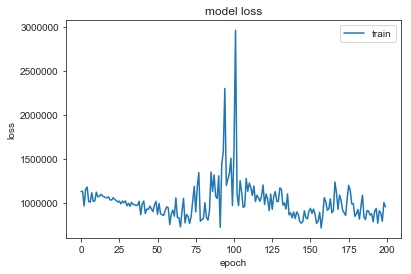

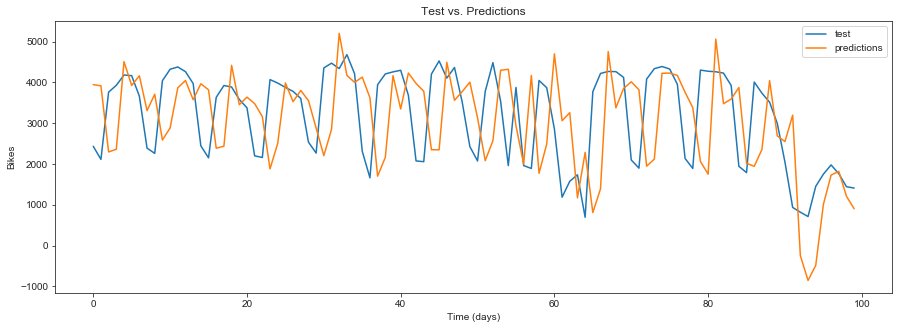

 > 1409.132
Epoch 1/200
35/35 [==============================] - 1s 33ms/step - loss: 1160192.7500
Epoch 2/200
35/35 [==============================] - 0s 2ms/step - loss: 1155393.0000
Epoch 3/200
35/35 [==============================] - 0s 2ms/step - loss: 1155468.1250
Epoch 4/200
35/35 [==============================] - 0s 2ms/step - loss: 1135769.7500
Epoch 5/200
35/35 [==============================] - 0s 6ms/step - loss: 1131950.0000
Epoch 6/200
35/35 [==============================] - 0s 3ms/step - loss: 1097631.7500
Epoch 7/200
35/35 [==============================] - 0s 2ms/step - loss: 1110515.8750
Epoch 8/200
35/35 [==============================] - 0s 2ms/step - loss: 1118477.8750
Epoch 9/200
35/35 [==============================] - 0s 2ms/step - loss: 1097518.7500
Epoch 10/200
35/35 [==============================] - 0s 2ms/step - loss: 1085065.7500
Epoch 11/200
35/35 [==============================] - 0s 2ms/step - loss: 1074160.8750
Epoch 12/200
35/35 [===================

Epoch 96/200
35/35 [==============================] - 0s 4ms/step - loss: 385218.5000
Epoch 97/200
35/35 [==============================] - 0s 3ms/step - loss: 502492.8125
Epoch 98/200
35/35 [==============================] - 0s 3ms/step - loss: 482903.7188
Epoch 99/200
35/35 [==============================] - 0s 2ms/step - loss: 372295.4375
Epoch 100/200
35/35 [==============================] - 0s 2ms/step - loss: 439026.1875
Epoch 101/200
35/35 [==============================] - 0s 2ms/step - loss: 440851.0938
Epoch 102/200
35/35 [==============================] - 0s 2ms/step - loss: 473159.8438
Epoch 103/200
35/35 [==============================] - 0s 2ms/step - loss: 349194.8438
Epoch 104/200
35/35 [==============================] - 0s 2ms/step - loss: 371592.6250
Epoch 105/200
35/35 [==============================] - 0s 2ms/step - loss: 440875.5312
Epoch 106/200
35/35 [==============================] - 0s 2ms/step - loss: 466413.0312
Epoch 107/200
35/35 [==========================

Epoch 190/200
35/35 [==============================] - 0s 2ms/step - loss: 470195.3750
Epoch 191/200
35/35 [==============================] - 0s 2ms/step - loss: 382523.7188
Epoch 192/200
35/35 [==============================] - 0s 2ms/step - loss: 357457.9375
Epoch 193/200
35/35 [==============================] - 0s 2ms/step - loss: 569047.3125
Epoch 194/200
35/35 [==============================] - 0s 3ms/step - loss: 499951.3125
Epoch 195/200
35/35 [==============================] - 0s 2ms/step - loss: 558898.6250
Epoch 196/200
35/35 [==============================] - 0s 11ms/step - loss: 447911.9375
Epoch 197/200
35/35 [==============================] - 0s 4ms/step - loss: 503240.1562
Epoch 198/200
35/35 [==============================] - 0s 3ms/step - loss: 655886.1875
Epoch 199/200
35/35 [==============================] - 0s 5ms/step - loss: 476659.2500
Epoch 200/200
35/35 [==============================] - 0s 7ms/step - loss: 584514.5000


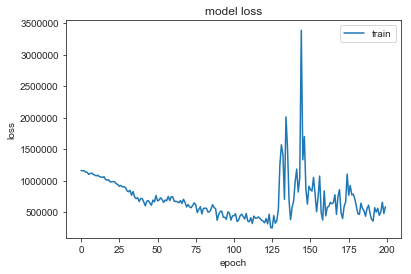

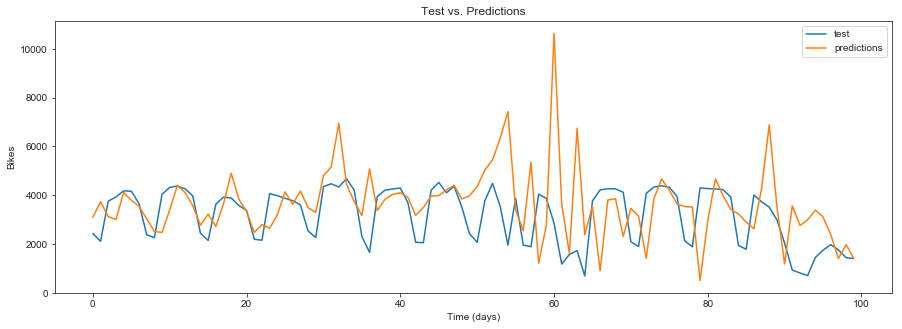

 > 1709.811
Epoch 1/200
35/35 [==============================] - 2s 61ms/step - loss: 1096707.2500
Epoch 2/200
35/35 [==============================] - 0s 2ms/step - loss: 1077555.2500
Epoch 3/200
35/35 [==============================] - 0s 2ms/step - loss: 1093744.6250
Epoch 4/200
35/35 [==============================] - 0s 1ms/step - loss: 1085055.6250
Epoch 5/200
35/35 [==============================] - 0s 1ms/step - loss: 1110355.8750
Epoch 6/200
35/35 [==============================] - 0s 2ms/step - loss: 1092218.7500
Epoch 7/200
35/35 [==============================] - 0s 2ms/step - loss: 1089223.2500
Epoch 8/200
35/35 [==============================] - 0s 2ms/step - loss: 1079572.7500
Epoch 9/200
35/35 [==============================] - 0s 2ms/step - loss: 1066987.8750
Epoch 10/200
35/35 [==============================] - 0s 2ms/step - loss: 1051249.2500
Epoch 11/200
35/35 [==============================] - 0s 2ms/step - loss: 1039725.0000
Epoch 12/200
35/35 [===================

Epoch 96/200
35/35 [==============================] - 0s 2ms/step - loss: 637691.0000
Epoch 97/200
35/35 [==============================] - 0s 2ms/step - loss: 756788.5625
Epoch 98/200
35/35 [==============================] - 0s 2ms/step - loss: 685452.1875
Epoch 99/200
35/35 [==============================] - 0s 2ms/step - loss: 623304.3750
Epoch 100/200
35/35 [==============================] - 0s 3ms/step - loss: 536965.3750
Epoch 101/200
35/35 [==============================] - 0s 2ms/step - loss: 684554.4375
Epoch 102/200
35/35 [==============================] - 0s 8ms/step - loss: 647048.0625
Epoch 103/200
35/35 [==============================] - 0s 6ms/step - loss: 576226.9375
Epoch 104/200
35/35 [==============================] - 0s 4ms/step - loss: 620753.5000
Epoch 105/200
35/35 [==============================] - 0s 5ms/step - loss: 591370.1250
Epoch 106/200
35/35 [==============================] - 0s 4ms/step - loss: 561678.9375
Epoch 107/200
35/35 [==========================

Epoch 191/200
35/35 [==============================] - 0s 2ms/step - loss: 254467.9375
Epoch 192/200
35/35 [==============================] - 0s 2ms/step - loss: 229003.5938
Epoch 193/200
35/35 [==============================] - 0s 2ms/step - loss: 226147.1406
Epoch 194/200
35/35 [==============================] - 0s 2ms/step - loss: 353636.4062
Epoch 195/200
35/35 [==============================] - 0s 2ms/step - loss: 285428.4688
Epoch 196/200
35/35 [==============================] - 0s 2ms/step - loss: 329421.3438
Epoch 197/200
35/35 [==============================] - 0s 2ms/step - loss: 255380.2031
Epoch 198/200
35/35 [==============================] - 0s 2ms/step - loss: 331428.8438
Epoch 199/200
35/35 [==============================] - 0s 2ms/step - loss: 219928.7031
Epoch 200/200
35/35 [==============================] - 0s 2ms/step - loss: 306721.8125


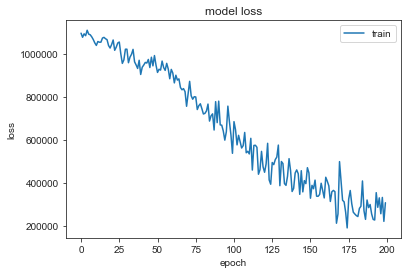

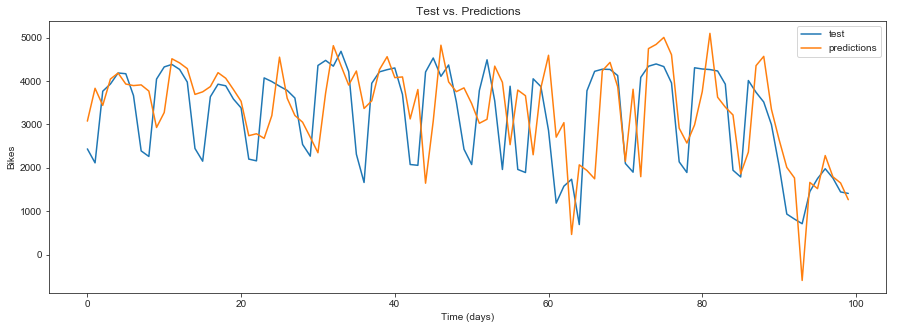

 > 1061.500
lstm: 1393.481 RMSE (+/- 264.903)


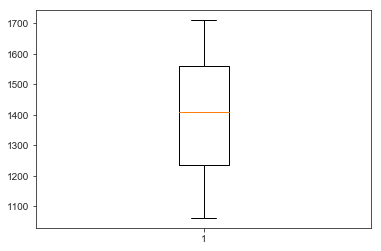

In [32]:
# evaluate lstm for monthly car sales dataset


# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
	return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    # one hidden layer
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
    model.add(Dropout(0.3))
    model.add(Dense(n_nodes, activation='relu'))
    # one unit output layer
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    hist = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=1)
    # list all data in history
#     print(hist.history.keys())
    plt.plot(hist.history['loss'])
#     plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    # plot test vs. predictions
    plt.figure(figsize=(15,5))
    plt.plot(test)
    plt.plot(predictions)
    plt.title('Test vs. Predictions')
    plt.ylabel('Bikes')
    plt.xlabel('Time (days)')
    plt.legend(['test', 'predictions'], loc='upper right')
    plt.show()
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=3):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [50]
    n_nodes = [50, 100]
    n_epochs = [50, 100]
    n_batch = [10, 50]
    n_diff = [2]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
                        print(cfg)
    print('Total configs: %d' % len(configs))
    return configs

# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

data = start_time_daily.values

# data split
n_test = 100

# define config
config = [50, 100, 200, 180, 2]
# config = [50, 50, 100, 100, 0]
# cfg_list = model_configs()

# grid search
scores = repeat_evaluate(data, config, n_test)
# scores = grid_search(data, cfg_list, n_test)

# list top 3 configs
# for cfg, error in scores[:3]:
#     print(cfg, error)

# summarize scores
summarize_scores('lstm', scores)

Train on 81 samples, validate on 94 samples
Epoch 1/300
81/81 [==============================] - 6s 75ms/step - loss: 728123.7500 - val_loss: 2295962.5000
Epoch 2/300
81/81 [==============================] - 0s 215us/step - loss: 713507.9375 - val_loss: 2276712.7500
Epoch 3/300
81/81 [==============================] - 0s 315us/step - loss: 705101.5625 - val_loss: 2255676.5000
Epoch 4/300
81/81 [==============================] - 0s 222us/step - loss: 692589.3750 - val_loss: 2237897.7500
Epoch 5/300
81/81 [==============================] - 0s 220us/step - loss: 682902.2500 - val_loss: 2217318.5000
Epoch 6/300
81/81 [==============================] - 0s 162us/step - loss: 677879.5000 - val_loss: 2198955.5000
Epoch 7/300
81/81 [==============================] - 0s 160us/step - loss: 676229.4375 - val_loss: 2181318.0000
Epoch 8/300
81/81 [==============================] - 0s 261us/step - loss: 661916.1875 - val_loss: 2162102.2500
Epoch 9/300
81/81 [==============================] - 0s 176us

Epoch 74/300
81/81 [==============================] - 0s 341us/step - loss: 92841.2188 - val_loss: 1172511.6250
Epoch 75/300
81/81 [==============================] - 0s 284us/step - loss: 102693.0312 - val_loss: 1156320.2500
Epoch 76/300
81/81 [==============================] - 0s 235us/step - loss: 95927.4453 - val_loss: 1151300.3750
Epoch 77/300
81/81 [==============================] - 0s 271us/step - loss: 103910.9141 - val_loss: 1139511.3750
Epoch 78/300
81/81 [==============================] - 0s 497us/step - loss: 125056.6641 - val_loss: 1115033.6250
Epoch 79/300
81/81 [==============================] - 0s 309us/step - loss: 109399.2969 - val_loss: 1101152.3750
Epoch 80/300
81/81 [==============================] - 0s 274us/step - loss: 115616.2500 - val_loss: 1161919.8750
Epoch 81/300
81/81 [==============================] - 0s 219us/step - loss: 132375.0938 - val_loss: 1120999.3750
Epoch 82/300
81/81 [==============================] - 0s 242us/step - loss: 106833.5078 - val_loss

Epoch 147/300
81/81 [==============================] - 0s 171us/step - loss: 60584.6406 - val_loss: 1175807.3750
Epoch 148/300
81/81 [==============================] - 0s 183us/step - loss: 46409.1719 - val_loss: 1186886.1250
Epoch 149/300
81/81 [==============================] - 0s 151us/step - loss: 43947.3320 - val_loss: 1186951.0000
Epoch 150/300
81/81 [==============================] - 0s 199us/step - loss: 49135.3047 - val_loss: 1189990.0000
Epoch 151/300
81/81 [==============================] - 0s 207us/step - loss: 54123.4648 - val_loss: 1217094.5000
Epoch 152/300
81/81 [==============================] - 0s 178us/step - loss: 46322.8672 - val_loss: 1229878.0000
Epoch 153/300
81/81 [==============================] - 0s 213us/step - loss: 51698.4062 - val_loss: 1230548.5000
Epoch 154/300
81/81 [==============================] - 0s 195us/step - loss: 51864.0742 - val_loss: 1218093.2500
Epoch 155/300
81/81 [==============================] - 0s 169us/step - loss: 56450.8828 - val_lo

Epoch 220/300
81/81 [==============================] - 0s 294us/step - loss: 33619.4883 - val_loss: 1221765.0000
Epoch 221/300
81/81 [==============================] - 0s 316us/step - loss: 36811.2383 - val_loss: 1210954.1250
Epoch 222/300
81/81 [==============================] - 0s 286us/step - loss: 43648.8477 - val_loss: 1221458.7500
Epoch 223/300
81/81 [==============================] - 0s 217us/step - loss: 38964.4766 - val_loss: 1233193.8750
Epoch 224/300
81/81 [==============================] - 0s 206us/step - loss: 34484.6055 - val_loss: 1248487.7500
Epoch 225/300
81/81 [==============================] - 0s 247us/step - loss: 27068.4414 - val_loss: 1257052.1250
Epoch 226/300
81/81 [==============================] - 0s 214us/step - loss: 43661.2969 - val_loss: 1271363.1250
Epoch 227/300
81/81 [==============================] - 0s 267us/step - loss: 44841.7969 - val_loss: 1275560.8750
Epoch 228/300
81/81 [==============================] - 0s 217us/step - loss: 41032.6367 - val_lo

Epoch 293/300
81/81 [==============================] - 0s 163us/step - loss: 23316.9102 - val_loss: 1212731.1250
Epoch 294/300
81/81 [==============================] - 0s 192us/step - loss: 31380.5996 - val_loss: 1215234.5000
Epoch 295/300
81/81 [==============================] - 0s 183us/step - loss: 42156.3711 - val_loss: 1228952.6250
Epoch 296/300
81/81 [==============================] - 0s 241us/step - loss: 27186.2129 - val_loss: 1240821.2500
Epoch 297/300
81/81 [==============================] - 0s 430us/step - loss: 26061.7168 - val_loss: 1240476.8750
Epoch 298/300
81/81 [==============================] - 0s 217us/step - loss: 26891.4141 - val_loss: 1236479.3750
Epoch 299/300
81/81 [==============================] - 0s 245us/step - loss: 39354.8906 - val_loss: 1239502.2500
Epoch 300/300
81/81 [==============================] - 0s 209us/step - loss: 26750.4004 - val_loss: 1244350.5000
dict_keys(['val_loss', 'loss'])


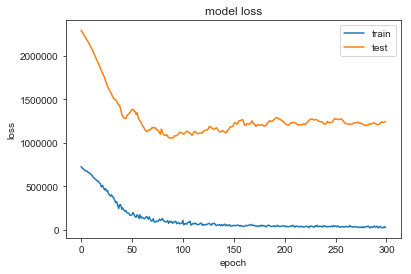

In [172]:
def model_fit2(data, config, n_test):
    train, test = data[:-n_test], data[-n_test:]
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
        test = difference(test, n_diff)
        data = series_to_supervised(train, n_input)
        train_x, train_y = data[:, :-1], data[:, -1]
        train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))

        data = series_to_supervised(test, n_input)
        test_x, test_y = data[:, :-1], data[:, -1]
        test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))   
    # define model
    model = Sequential()
    # one hidden layer
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
    model.add(Dropout(0.3))
    model.add(Dense(n_nodes, activation='relu'))
    # one unit output layer
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    hist = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=1, validation_data=(test_x, test_y))
    # list all data in history
    print(hist.history.keys())
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    return

def walk_forward_validation2(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit2(data, cfg, n_test)
    # seed history with training dataset
    history = [x for x in train]

data = start_time_daily.values
n_test = 100
config = [4, 100, 300, 180, 2]

# model_fit(data, config, 50)
walk_forward_validation2(data, n_test, config)


### 12.2. LSTM RNN Hourly Forecast

Epoch 1/100
3102/3102 [==============================] - 12s 4ms/step - loss: 2.5534
Epoch 2/100
3102/3102 [==============================] - 0s 93us/step - loss: 1.9049
Epoch 3/100
3102/3102 [==============================] - 0s 105us/step - loss: 1.5605
Epoch 4/100
3102/3102 [==============================] - 0s 128us/step - loss: 1.5633
Epoch 5/100
3102/3102 [==============================] - 0s 86us/step - loss: 1.5233
Epoch 6/100
3102/3102 [==============================] - 0s 111us/step - loss: 1.4565
Epoch 7/100
3102/3102 [==============================] - 0s 95us/step - loss: 1.4022
Epoch 8/100
3102/3102 [==============================] - 0s 94us/step - loss: 1.3996
Epoch 9/100
3102/3102 [==============================] - 0s 89us/step - loss: 1.3825
Epoch 10/100
3102/3102 [==============================] - 0s 101us/step - loss: 1.3741
Epoch 11/100
3102/3102 [==============================] - 0s 92us/step - loss: 1.3594
Epoch 12/100
3102/3102 [==============================] - 0

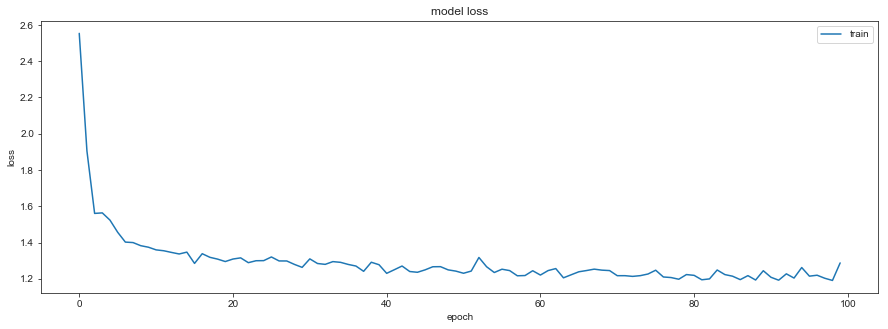

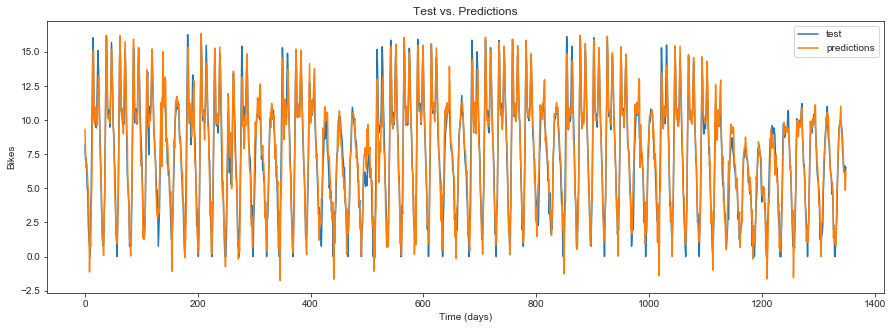

 > 1.186
Epoch 1/100
3102/3102 [==============================] - 8s 3ms/step - loss: 2.4999
Epoch 2/100
3102/3102 [==============================] - 1s 258us/step - loss: 1.9484
Epoch 3/100
3102/3102 [==============================] - 1s 250us/step - loss: 1.6143 0s - 
Epoch 4/100
3102/3102 [==============================] - 1s 208us/step - loss: 1.5424
Epoch 5/100
3102/3102 [==============================] - 0s 150us/step - loss: 1.4792
Epoch 6/100
3102/3102 [==============================] - 1s 164us/step - loss: 1.4250
Epoch 7/100
3102/3102 [==============================] - 0s 111us/step - loss: 1.4047
Epoch 8/100
3102/3102 [==============================] - 0s 107us/step - loss: 1.3792
Epoch 9/100
3102/3102 [==============================] - 0s 101us/step - loss: 1.3445
Epoch 10/100
3102/3102 [==============================] - 0s 118us/step - loss: 1.3497
Epoch 11/100
3102/3102 [==============================] - 1s 165us/step - loss: 1.3657
Epoch 12/100
3102/3102 [===============

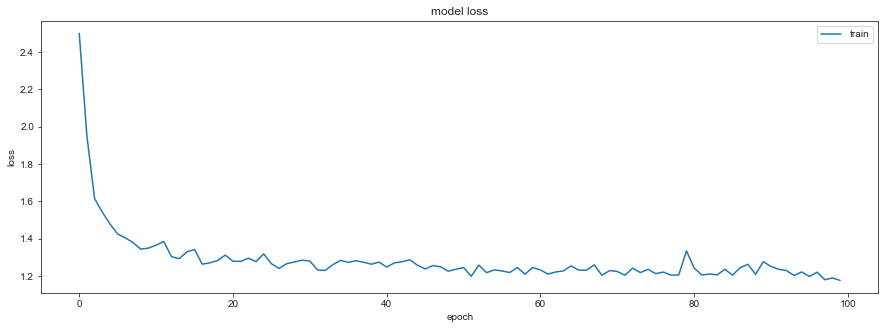

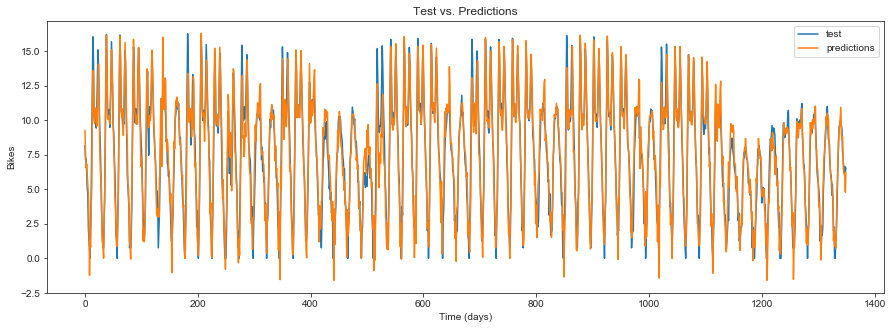

 > 1.212
Epoch 1/100
3102/3102 [==============================] - 8s 3ms/step - loss: 2.5476
Epoch 2/100
3102/3102 [==============================] - 0s 119us/step - loss: 1.8977
Epoch 3/100
3102/3102 [==============================] - 0s 125us/step - loss: 1.6122
Epoch 4/100
3102/3102 [==============================] - 0s 144us/step - loss: 1.5702 0s - loss: 1
Epoch 5/100
3102/3102 [==============================] - 0s 141us/step - loss: 1.4961
Epoch 6/100
3102/3102 [==============================] - 1s 221us/step - loss: 1.4438 0s - los
Epoch 7/100
3102/3102 [==============================] - 0s 118us/step - loss: 1.4124
Epoch 8/100
3102/3102 [==============================] - 0s 160us/step - loss: 1.4400
Epoch 9/100
3102/3102 [==============================] - 0s 126us/step - loss: 1.3756
Epoch 10/100
3102/3102 [==============================] - 1s 172us/step - loss: 1.3917
Epoch 11/100
3102/3102 [==============================] - 1s 175us/step - loss: 1.3565
Epoch 12/100
3102/3102 

Epoch 94/100
3102/3102 [==============================] - 1s 204us/step - loss: 1.2069
Epoch 95/100
3102/3102 [==============================] - 0s 140us/step - loss: 1.2035
Epoch 96/100
3102/3102 [==============================] - 0s 150us/step - loss: 1.2272
Epoch 97/100
3102/3102 [==============================] - 1s 172us/step - loss: 1.2032
Epoch 98/100
3102/3102 [==============================] - 1s 203us/step - loss: 1.2098
Epoch 99/100
3102/3102 [==============================] - 1s 220us/step - loss: 1.2242
Epoch 100/100
3102/3102 [==============================] - 1s 189us/step - loss: 1.1808


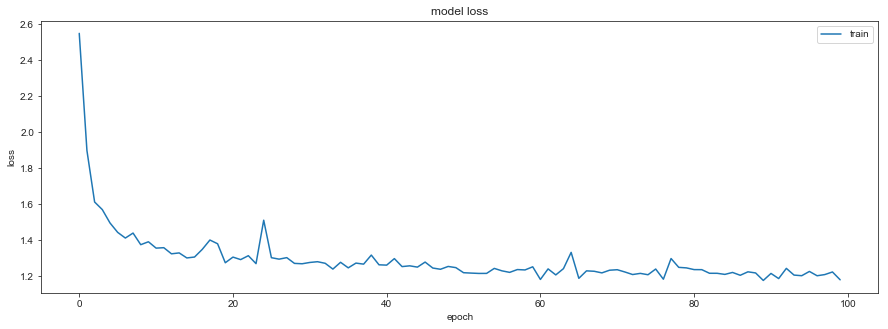

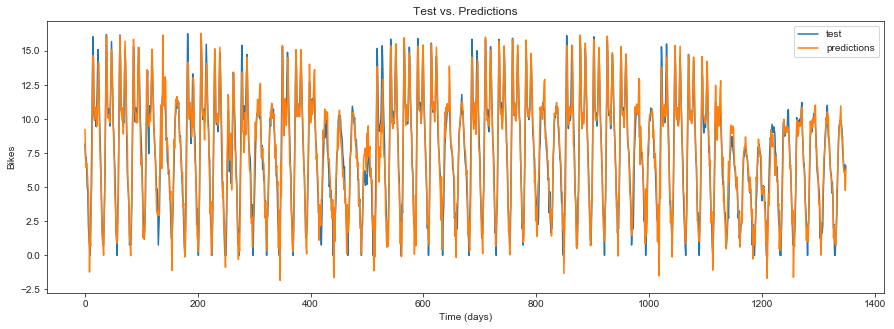

 > 1.177
lstm: 1.192 RMSE (+/- 0.015)


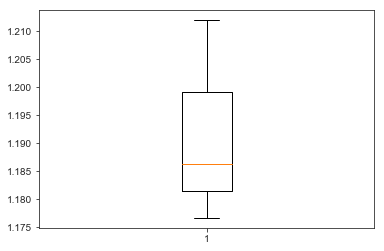

In [176]:
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    # one hidden layer
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(n_nodes, activation='relu'))
    # one unit output layer
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    hist = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=1)
    # list all data in history
    plt.figure(figsize=(15,5))
#     print(hist.history.keys())
    plt.plot(hist.history['loss'])
#     plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    return model

data = log_start_time_hourly.values

# data split
n_test = 1350
# define config
config = [3, 100, 100, 100, 24]
# cfg_list = model_configs()

# grid search
scores = repeat_evaluate(data, config, n_test)
# scores = grid_search(data, cfg_list, n_test)

# list top 3 configs
# for cfg, error in scores[:3]:
#     print(cfg, error)

# summarize scores
summarize_scores('lstm', scores)

Train on 3102 samples, validate on 1323 samples
Epoch 1/100
3102/3102 [==============================] - 8s 3ms/step - loss: 2.6445 - val_loss: 2.3571
Epoch 2/100
3102/3102 [==============================] - 0s 117us/step - loss: 1.9620 - val_loss: 1.7824
Epoch 3/100
3102/3102 [==============================] - ETA: 0s - loss: 1.630 - 0s 121us/step - loss: 1.6013 - val_loss: 1.6020
Epoch 4/100
3102/3102 [==============================] - 0s 126us/step - loss: 1.5414 - val_loss: 1.5065
Epoch 5/100
3102/3102 [==============================] - 0s 118us/step - loss: 1.5059 - val_loss: 1.4981
Epoch 6/100
3102/3102 [==============================] - 0s 127us/step - loss: 1.4636 - val_loss: 1.4885
Epoch 7/100
3102/3102 [==============================] - 0s 153us/step - loss: 1.3854 - val_loss: 1.4180
Epoch 8/100
3102/3102 [==============================] - 0s 148us/step - loss: 1.4210 - val_loss: 1.4288
Epoch 9/100
3102/3102 [==============================] - 0s 142us/step - loss: 1.3728 - va

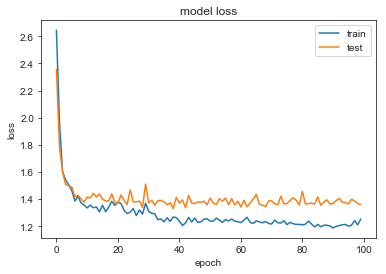

In [180]:
def model_fit3(data, config, n_test):
    train, test = data[:-n_test], data[-n_test:]
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
        test = difference(test, n_diff)
        data = series_to_supervised(train, n_input)
        train_x, train_y = data[:, :-1], data[:, -1]
        train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))

        data = series_to_supervised(test, n_input)
        test_x, test_y = data[:, :-1], data[:, -1]
        test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))   
    # define model
    model = Sequential()
    # one hidden layer
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(n_nodes, activation='relu'))
    # one unit output layer
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    hist = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=1, validation_data=(test_x, test_y))
    # list all data in history
    print(hist.history.keys())
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    return

def walk_forward_validation3(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit3(data, cfg, n_test)
    # seed history with training dataset
    history = [x for x in train]
    
data = log_start_time_hourly.values
n_test = 1350
config = [3, 100, 100, 100, 24]

walk_forward_validation3(data, n_test, config)

## 13. Limitations
- The forecast is based on an aggregate view of bike rides and is not meant to be used for bike station rebalancing.
- The forecast is relevant for bikes that are docked at bike stations, but may not be relevant for dockless electric scooters and bikes.
- The dataset only provides a roughly a half year worth of data, LSTM RNN models may not be able to obtain trends with long time dependencies.

## 14. Future Work
- Investigate multivariate forecasting to determine how other time-dependent variables affect the output, e.g. weather, air quality.
- Use additional data from 2018 to further improve the LSTM model

## 16. Major Findings and Client Recommendations
- Major Findings:
    - The ARIMA models outperformed the persistence model and the LSTM model for both time the hourly and daily time series
    - The LSTM RNN models were able to outperform the persistence model at the hourly timestep, but was parity at the daily timestep.
- Client Recommendations:
    - Ford GoBike: Use the ARIMA model for time series forecasting, but as the company operates for a longer period of time consider LSTM RNNs as an alternative.
    - Bay Area City Planners: 
        - Focus planning efforts near the downtown SF area, followed by Downtown Oakland, then Berkeley for docked bike stations
        - Use the ARIMA model for time series forecasting of new bike sharing companies like Ford GoBike, but as a company operates for a longer period of time consider LSTM RNNs as an alternative for demand forecasting.

## 17. Acknowledgements
The author would like to thanks Springboard and especially his mentor for the advice and support throughout the capstone project.